## Maximum Likelihood Lab

In this lab we will look at the DMV waiting time example from the class. Let's look at the following situation:

You want to find out how long your mom will have to wait at the DMV. In order to determine the waiting time you stayed at the DMV for a while and measured the waiting time for the customers. You were playing on your phone and so you missed to to measure the exact time. Thus you started to collect the waiting times in the form (5, 0.3), which in this example means that the waiting time was somewhere between 5-0.3 and 5+0.3 minutes. 

Now that you have your data you want to build a model. You now assume that all waiting times $W_i$ are distributed with the same **but unknown** gamma distribution with **fixed but unknown** hyperparameters $\alpha$ and $\beta$ and that all waiting times $W_i$ are independent and thus

$$P_{(\beta, \alpha)}(W_1 \in A_1, W_2 \in A_2, ..., W_N \in A_N) = \Gamma_{(\beta, \alpha)}(W_1 \in A_1)\Gamma_{(\beta, \alpha)}(W_2 \in A_2)... \Gamma_{(\beta, \alpha)}(W_N \in A_N)$$

Please take a moment and think about the 3 major assumptions:
1. The waiting times are independet.
2. All waiting times are distributed from the same type of distribution.
3. We are certain that the hyperparameters take one specific value. We just don't know which one it is. 

**Exercise 1:**

Create a lambda expression for the Gamma distribution. You will need the gamma function $\Gamma$ which is available in the scipy.special package. Plot the Gamma distribution for 4 different combinations of $\beta$ and $\alpha$ onto the same graph. Describe how the hyperparameters $\beta$ and $\alpha$ change the shape of the distribution.

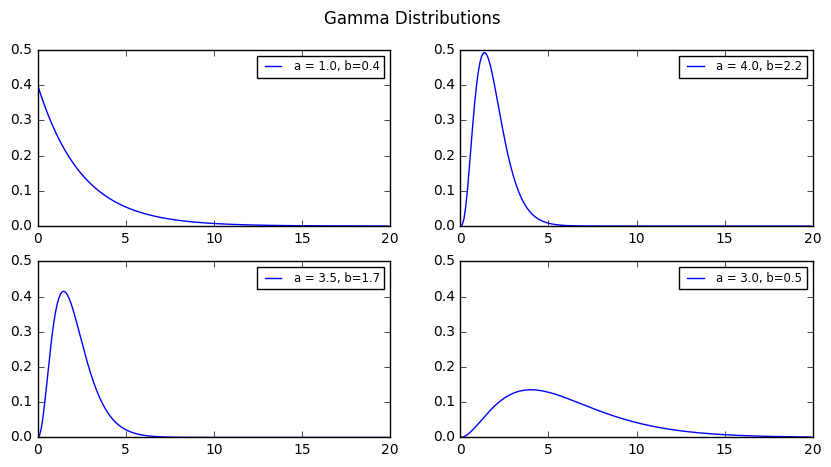

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import binom as binomial
from scipy.special import gamma
from scipy.integrate import quad
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Gamma distribution expression
GD = lambda a,b : lambda x: ((b**a)*(x**(a-1))*(np.exp(-x*b)))/gamma(a)
X = np.arange(0,20,.1)
a = [1.,4.,3.5,3.]
b = [.4,2.2,1.7,.5]
zipped = zip(a,b)
fig, ax = plt.subplots(2,2,figsize=(10,5))
ax = ax.reshape(4,)
zipped2 = zip(ax,zipped)

for e in zipped2:
    e[0].plot(X,GD(*e[1])(X), label = 'a = {0}, b={1}'.format(*e[1]))
    e[0].legend(loc = 'best', fontsize = 'small')
    e[0].set_ylim([0,.5])
    
plt.suptitle('Gamma Distributions', fontsize = 'large')

# Increasing the Alpha loosens the distribution, makes the peak lower, the base wider,\
# and moves the peak to the right.  This adds uncertainty.
    
# Increasing the Beta tightens the distribution, makes the peak taller, the base narrower,\
# and moves the peak to the left.  This reduces uncertainty.

# Increasing the beta and increasing the alpha have opposite effects on the distribution.

**Exercise 2:**

The data points that you collected are in the below list denoted by waiting_time. Each of the tuples in the list represents an intervall of time that you measured. You can now use the below data points to calculate the probability of the measured intervalls as a function of $(\beta, \alpha)$

$$(\beta, \alpha) \to P_{(\beta, \alpha)}( W_1 \in [3.8,4.2), W_2 \in [3.5, 4.5), W_3 \in [4.1, 5.9), ...)$$

Create a lambda expression that maps every pair $(\beta, \alpha)$ onto the probability and craete a 3D plot. You will need to use numpy.vectorize to vectorize the lambda expression. Numpy converts the lambda expression so that it can take numpy arrays as arguments. Look into last weeks notes to find out how to plot a 3D plot.

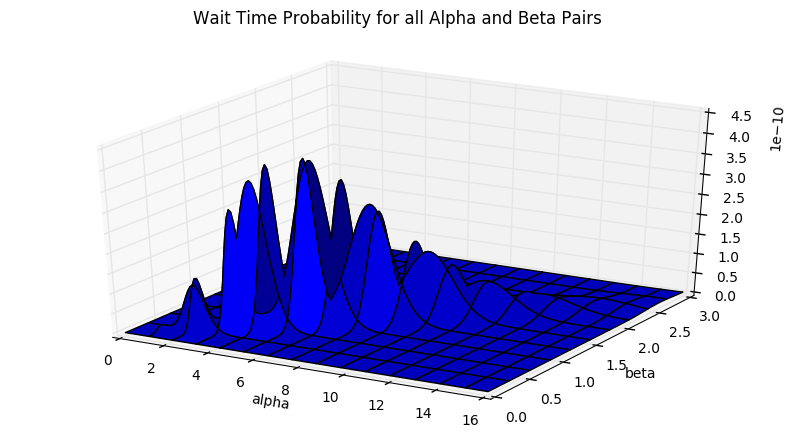

In [2]:
waiting_time =[(4,0.2),(4,0.5), (5,0.9), (6,0.2), (4,0.2), (6,0.2), (5,0.6), (15,0.6)]
wait_time = [(y[0] - y[1], y[0] + y[1]) for y in waiting_time]
# for every value of alpha and beta, this lambda expression takes the product of the wait time \
# probability for each of the wait time pairs
GD1 = lambda a,b: np.prod([quad(lambda x: GD(a,b)(x),\
                wait_time[i][0],wait_time[i][1])[0]for i in range(len(wait_time))])

b = np.linspace(0.01,3, 100)
a = np.linspace(0.01,16, 150)
a, b = np.meshgrid(a,b)
DV = np.vectorize(GD1)
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,1,1, projection = '3d')
ax1.plot_surface(a, b, DV(a, b))
plt.title("Wait Time Probability for all Alpha and Beta Pairs",y=1.1)
plt.xlabel('alpha')
plt.ylabel('beta',y=.90)

**Exercise 3:**

Each of the points $(\beta, \alpha)$ represents a model that we could pick and the plot shows us how likely the measured waiting times are if we would have fixed $(\beta, \alpha)$ at the respective values. We now have to make a decision which pair $(\beta, \alpha)$ we want to pick. One way to approach this decision problem is to pick the $(\beta, \alpha)$ pair which produces the highest probability for the measured event. This approach is called **Maximum Likelihood**. 

Use the minimize function in the scipy.optimize package to find the maximum likelihood. You will have to change the function so that the maximum becomes the minimum. Additionally, minimize only takes functions of one variable. You will have to change your function so that it takes a list as an argument and not two numbers. minimize looks for a minimum around an initial point x0. You will have to provide such a point. Use method = 'Nelder-Mead'. 

See below for an example of how to use minimize.

In [3]:
ab0 = [5,1.25]
# takes the inverse of our function so we can calc the minimum
GD2 = lambda a,b: -1 * np.prod([quad(lambda x: GD(a,b)(x),\
                  wait_time[i][0],wait_time[i][1])[0]for i in range(len(wait_time))])

MinGD = lambda x: GD2(x[0], x[1])
MinGD1 = minimize(MinGD,ab0,method = 'Nelder-Mead')
print (MinGD1.x)
plotlist = list(MinGD1.x)

[ 4.95835203  0.81043573]


**Exercise 4:**

Now that we have our maximum likelihood solution we can take a step back and think about what we just did. 

* Take a look at the plot and remind yourself that minimize looks for a solution around an initial point x0. What's the problem with that?
* We assumed that the outcome that we measured is the outcome with the hightest probability. Take a look at the actual probability of getting what we measured under the assumption of the model. How likely was it? 
* Take a moment and check out what outliers are. How do those data points effect the solution in light of the above point and why?
* Can you think of a way to make a better decision?

In [4]:
# Q1)
# The problem with starting with the x0 approach is that you have to be able to pick the point in the
# valley of the steepest trough.  It is difficult to precisely measure where to begin in order to accurately
# capture the maximum probability.
#
# Q2) The actual probability of getting these wait times is very unlikely.
#
# Q3)
# By removing the outlier, you get a much higher probability of getting these wait times.  
#
# Q4)
# You could use Bayes to make a better decision.

**Exercise 5:**

Plot the distribution of the maximum likelihood solution together with a normed histogram of the waiting times. What can you observe and how does this relate to Exercise 4?

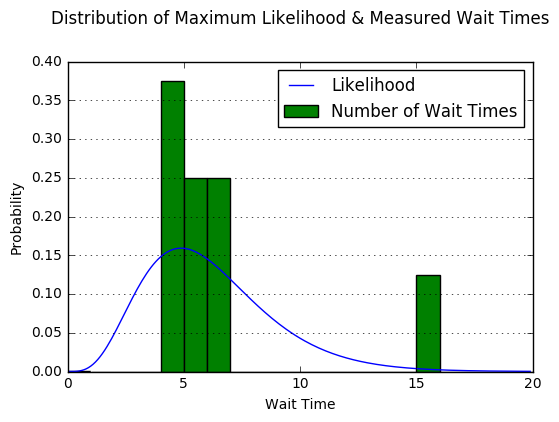

In [5]:
# Uses the maximum likelihood alpha and beta pair for your distribution
GDBP = lambda x: ((plotlist[1]**plotlist[0])*(x**(plotlist[0]-1))*(np.exp(-x*plotlist[1])))/gamma(plotlist[0])
plt.plot(X,GDBP(X),label = 'Likelihood')
plt.hist([x[0] for x in waiting_time],normed=True, bins = range(0,21,1),label = 'Number of Wait Times')
plt.grid(axis='y')
plt.xlabel("Wait Time")
plt.ylabel("Probability")
plt.title("Distribution of Maximum Likelihood & Measured Wait Times", fontsize=12, y=1.1)
plt.legend(loc='best')
plt.show()

**Exercise 6:**

Calculate the Mean and the Variance of the maximum likelihood distribution using integration. Remember: The Mean of the distribution $E[W]$ is the expected waiting time and the square root of the variance $\sqrt{Var[W]}$ is the expected range of waiting times.

In [6]:
# Calcs the mean and the variance
fmean = quad(lambda m: GDBP(m)*m,0,np.infty)[0]
fvar = quad(lambda m: GDBP(m)*(m**2),0,np.infty)[0] - (fmean**2)

print("The mean is: {0: .2f}".format(fmean))
print("The variance is: {0: .2f}".format(fvar))

The mean is:  6.12
The variance is:  7.55


**Exercise 7:**

Use the minimize function to calculate the waiting time with the hightest probability and its respective probability. Compare your result to the result of Exercise 6. Does this make you think about a better decision methedology for $(\beta, \alpha)$?

The waiting time with the highest probability is 4.88 minutes and its respective probability is 15.91%


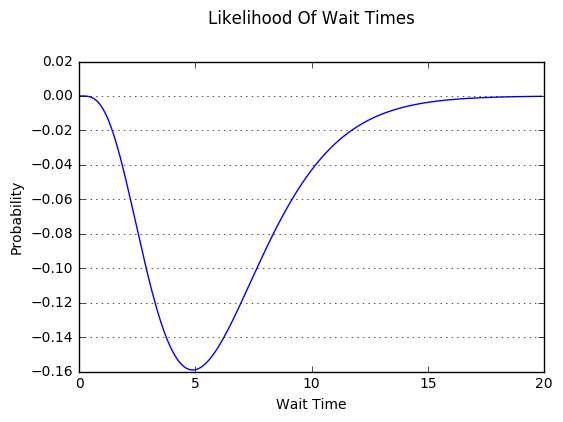

In [7]:
# Inverts the maximum liklihood alpha and beta pair for your distribution so you can get the minimum
GDBP2 = lambda x: ((plotlist[1]**plotlist[0])*(x**(plotlist[0]-1))*(np.exp(-x*plotlist[1])))/gamma(plotlist[0]) * -1
plt.plot(X,GDBP2(X))
plt.ylabel('Probability')
plt.xlabel('Wait Time')
plt.grid(axis='y')
plt.title("Likelihood Of Wait Times", fontsize=12, y=1.1)

x0 = 6
MinGDBP2 = minimize(GDBP2,x0,method = 'Nelder-Mead')

print ('The waiting time with the highest probability is{0: .2f} minutes and its respective probability is{1: .2%}'\
       .format(float(MinGDBP2.x),float(GDBP(MinGDBP2.x))))

# The expected waiting time is greater than the waiting time with the highest probability.
# The expected waiting time should equal the waiting time with the highest probability.